In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
# # standardize based on each batch
# for i in range(len(train_input)):
#     train_input[i] = (train_input[i]-np.mean(train_input[i]))/np.std(train_input[i])

# for i in range(len(train_output)):
#     train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

# for i in range(len(val_input)):
#     val_input[i] = (val_input[i]-np.mean(val_input[i]))/np.std(val_input[i])

# for i in range(len(val_output)):
#     val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
integrade_data_raw = pd.read_csv('gex.combined.sct.csv')
integrade_meta_raw = pd.read_csv('gex.combined.sct.obs.csv')

In [25]:
integrade_data = integrade_data_raw
integrade_meta = integrade_meta_raw

In [26]:
integrade_data = integrade_data.transpose()

In [27]:
integrade_data = integrade_data.iloc[1:, :]

In [28]:
integrade_data.reset_index(drop=True, inplace=True)
integrade_data['batch'] = integrade_meta['batch']

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s4d1', 's4d8', 's4d9']

In [29]:
s1d1_integrade_data = integrade_data[integrade_data['batch'] == 's1d1']
s1d2_integrade_data = integrade_data[integrade_data['batch'] == 's1d2']
s1d3_integrade_data = integrade_data[integrade_data['batch'] == 's1d3']
s2d1_integrade_data = integrade_data[integrade_data['batch'] == 's2d1']
s2d4_integrade_data = integrade_data[integrade_data['batch'] == 's2d4']
s2d5_integrade_data = integrade_data[integrade_data['batch'] == 's2d5']
s3d1_integrade_data = integrade_data[integrade_data['batch'] == 's3d1']
s3d6_integrade_data = integrade_data[integrade_data['batch'] == 's3d6']
s3d7_integrade_data = integrade_data[integrade_data['batch'] == 's3d7']

In [30]:
s4d1_integrade_data = integrade_data[integrade_data['batch'] == 's4d1']
s4d8_integrade_data = integrade_data[integrade_data['batch'] == 's4d8']
s4d9_integrade_data = integrade_data[integrade_data['batch'] == 's4d9']

In [31]:
s1d1_inte_np = s1d1_integrade_data.iloc[:, :-1].to_numpy()
s1d2_inte_np = s1d2_integrade_data.iloc[:, :-1].to_numpy()
s1d3_inte_np = s1d3_integrade_data.iloc[:, :-1].to_numpy()
s2d1_inte_np = s2d1_integrade_data.iloc[:, :-1].to_numpy()
s2d4_inte_np = s2d4_integrade_data.iloc[:, :-1].to_numpy()
s2d5_inte_np = s2d5_integrade_data.iloc[:, :-1].to_numpy()
s3d1_inte_np = s3d1_integrade_data.iloc[:, :-1].to_numpy()
s3d6_inte_np = s3d6_integrade_data.iloc[:, :-1].to_numpy()
s3d7_inte_np = s3d7_integrade_data.iloc[:, :-1].to_numpy()

In [32]:
s4d1_inte_np = s4d1_integrade_data.iloc[:, :-1].to_numpy()
s4d8_inte_np = s4d8_integrade_data.iloc[:, :-1].to_numpy()
s4d9_inte_np = s4d9_integrade_data.iloc[:, :-1].to_numpy()

In [33]:
train_input_inte = np.concatenate([s1d1_inte_np, s1d2_inte_np, s1d3_inte_np, s2d1_inte_np, s2d4_inte_np, s2d5_inte_np, s3d1_inte_np, s3d6_inte_np, s3d7_inte_np], axis=0)
val_input_inte = np.concatenate([s3d1_inte_np, s3d6_inte_np, s3d7_inte_np], axis=0)
test_input_inte = np.concatenate([s4d1_inte_np, s4d8_inte_np, s4d9_inte_np], axis=0)

In [34]:
train_input = train_input_inte
val_input = val_input_inte
test_input = test_input_inte

In [35]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

(66175, 3000)
(28921, 3000)
(1000, 3000)


In [36]:
train_input = np.float64(train_input)
val_input = np.float64(val_input)
test_input = np.float64(test_input)

In [37]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [38]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [39]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [40]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [41]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [42]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [43]:
batch_train = batch_train + batch_val

In [44]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([66175, 1])

In [45]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([28921, 1])

In [46]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 1])

In [47]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [48]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [49]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [50]:
PATH = 'No_norm_model_RNA_pro_inte'

In [51]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (10, 4*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.55692405  Validation_loss:  0.51916194  Test_loss:  0.5291315


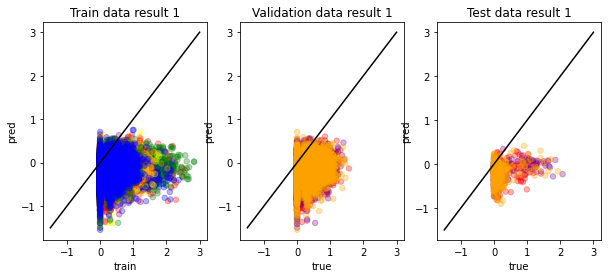

Epoch  100 Train_loss:  0.2501113  Validation_loss:  0.22812866  Test_loss:  0.24575658
Epoch  200 Train_loss:  0.23873542  Validation_loss:  0.21558324  Test_loss:  0.24079798
Epoch  300 Train_loss:  0.23467137  Validation_loss:  0.21174797  Test_loss:  0.23715171
Epoch  400 Train_loss:  0.23271933  Validation_loss:  0.21043628  Test_loss:  0.23451407
Epoch  500 Train_loss:  0.2315111  Validation_loss:  0.20936996  Test_loss:  0.23272428
Epoch  600 Train_loss:  0.2306125  Validation_loss:  0.20840131  Test_loss:  0.23140179
Epoch  700 Train_loss:  0.22983477  Validation_loss:  0.20805617  Test_loss:  0.22990993
Epoch  800 Train_loss:  0.22913387  Validation_loss:  0.20782001  Test_loss:  0.22861531
Epoch  900 Train_loss:  0.22847408  Validation_loss:  0.207254  Test_loss:  0.22776154
Epoch  1000 Train_loss:  0.22784393  Validation_loss:  0.20708172  Test_loss:  0.22683395


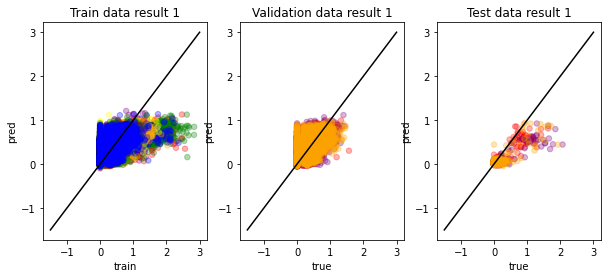

Epoch  1100 Train_loss:  0.22723164  Validation_loss:  0.20673667  Test_loss:  0.22596194
Epoch  1200 Train_loss:  0.22662519  Validation_loss:  0.20640542  Test_loss:  0.22536767
Epoch  1300 Train_loss:  0.22602743  Validation_loss:  0.20634694  Test_loss:  0.22450383
Epoch  1400 Train_loss:  0.2254512  Validation_loss:  0.2057571  Test_loss:  0.22422127
Epoch  1500 Train_loss:  0.22487815  Validation_loss:  0.20524137  Test_loss:  0.2239564
Epoch  1600 Train_loss:  0.22429962  Validation_loss:  0.20505552  Test_loss:  0.22328454
Epoch  1700 Train_loss:  0.2237326  Validation_loss:  0.20467219  Test_loss:  0.22299354
Epoch  1800 Train_loss:  0.22315441  Validation_loss:  0.20470597  Test_loss:  0.22233278
Epoch  1900 Train_loss:  0.22259194  Validation_loss:  0.20407663  Test_loss:  0.22216755
Epoch  2000 Train_loss:  0.22202796  Validation_loss:  0.20363675  Test_loss:  0.22203001


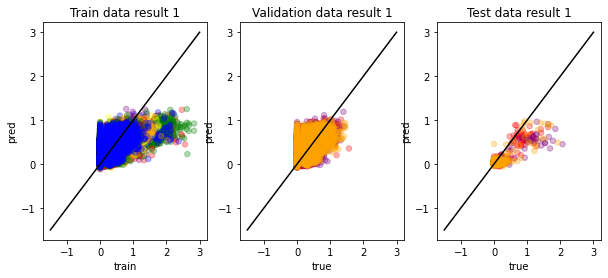

Epoch  2100 Train_loss:  0.2214723  Validation_loss:  0.20328622  Test_loss:  0.22162996
Epoch  2200 Train_loss:  0.2209109  Validation_loss:  0.2031207  Test_loss:  0.22116645
Epoch  2300 Train_loss:  0.22034702  Validation_loss:  0.2029998  Test_loss:  0.22059286
Epoch  2400 Train_loss:  0.21978995  Validation_loss:  0.20237932  Test_loss:  0.22079983
Epoch  2500 Train_loss:  0.21922997  Validation_loss:  0.20237304  Test_loss:  0.22024645
Epoch  2600 Train_loss:  0.21867381  Validation_loss:  0.20194937  Test_loss:  0.22005156
Epoch  2700 Train_loss:  0.21812424  Validation_loss:  0.20138882  Test_loss:  0.22000599
Epoch  2800 Train_loss:  0.21756068  Validation_loss:  0.20111565  Test_loss:  0.21971518
Epoch  2900 Train_loss:  0.21699485  Validation_loss:  0.20085016  Test_loss:  0.21943581
Epoch  3000 Train_loss:  0.21643423  Validation_loss:  0.20031793  Test_loss:  0.21940584


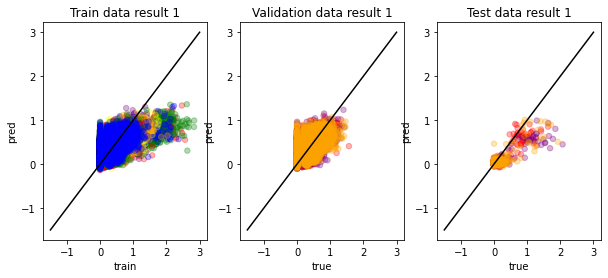

Epoch  3100 Train_loss:  0.21586065  Validation_loss:  0.19979803  Test_loss:  0.21937679
Epoch  3200 Train_loss:  0.21527237  Validation_loss:  0.19961622  Test_loss:  0.21904354
Epoch  3300 Train_loss:  0.21468024  Validation_loss:  0.19918045  Test_loss:  0.21885361
Epoch  3400 Train_loss:  0.21409146  Validation_loss:  0.1987068  Test_loss:  0.2188925
Epoch  3500 Train_loss:  0.21349335  Validation_loss:  0.19813704  Test_loss:  0.21881232
Epoch  3600 Train_loss:  0.21287744  Validation_loss:  0.19823444  Test_loss:  0.21809626
Epoch  3700 Train_loss:  0.21227437  Validation_loss:  0.19731495  Test_loss:  0.21857627
Epoch  3800 Train_loss:  0.21164416  Validation_loss:  0.1969702  Test_loss:  0.21824719
Epoch  3900 Train_loss:  0.21100366  Validation_loss:  0.19674686  Test_loss:  0.21793848
Epoch  4000 Train_loss:  0.21035509  Validation_loss:  0.1963575  Test_loss:  0.21763238


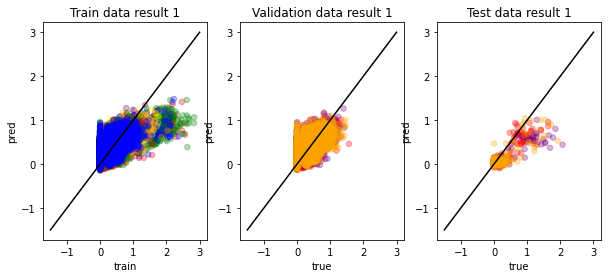

Epoch  4100 Train_loss:  0.20971344  Validation_loss:  0.19537818  Test_loss:  0.21813981
Epoch  4200 Train_loss:  0.20903043  Validation_loss:  0.1954395  Test_loss:  0.21743567
Epoch  4300 Train_loss:  0.20834439  Validation_loss:  0.19473965  Test_loss:  0.21751477
Epoch  4400 Train_loss:  0.20764963  Validation_loss:  0.19422029  Test_loss:  0.2174679
Epoch  4500 Train_loss:  0.20694226  Validation_loss:  0.1935691  Test_loss:  0.21743211
Epoch  4600 Train_loss:  0.20621501  Validation_loss:  0.19304247  Test_loss:  0.2173864
Epoch  4700 Train_loss:  0.2054636  Validation_loss:  0.19261724  Test_loss:  0.21718612
Epoch  4800 Train_loss:  0.2046943  Validation_loss:  0.19181696  Test_loss:  0.21729629
Epoch  4900 Train_loss:  0.20390497  Validation_loss:  0.19144665  Test_loss:  0.21704422
Epoch  5000 Train_loss:  0.20310986  Validation_loss:  0.19071853  Test_loss:  0.21699984


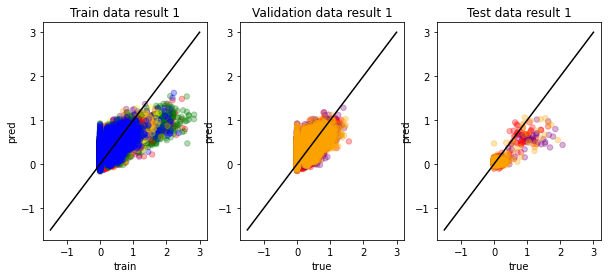

Epoch  5100 Train_loss:  0.20229067  Validation_loss:  0.19013701  Test_loss:  0.21703447
Epoch  5200 Train_loss:  0.20145687  Validation_loss:  0.18950967  Test_loss:  0.21693674
Epoch  5300 Train_loss:  0.20058122  Validation_loss:  0.18908118  Test_loss:  0.2165522
Epoch  5400 Train_loss:  0.19971678  Validation_loss:  0.18801387  Test_loss:  0.2168848
Epoch  5500 Train_loss:  0.1988057  Validation_loss:  0.18730064  Test_loss:  0.21675797
Epoch  5600 Train_loss:  0.19788525  Validation_loss:  0.1866503  Test_loss:  0.21656294
Epoch  5700 Train_loss:  0.19692168  Validation_loss:  0.1859069  Test_loss:  0.21644907
Epoch  5800 Train_loss:  0.19595361  Validation_loss:  0.18497346  Test_loss:  0.21666844
Epoch  5900 Train_loss:  0.19494677  Validation_loss:  0.18432608  Test_loss:  0.21645074
Epoch  6000 Train_loss:  0.19394857  Validation_loss:  0.18353146  Test_loss:  0.21650992


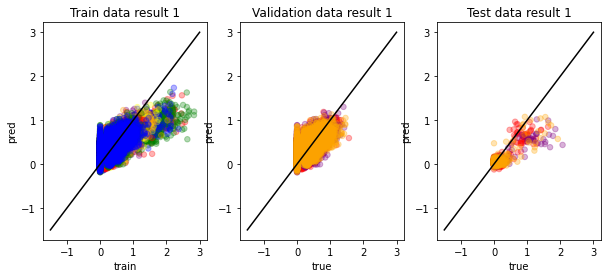

Epoch  6100 Train_loss:  0.19290727  Validation_loss:  0.18275785  Test_loss:  0.21621434
Epoch  6200 Train_loss:  0.19184814  Validation_loss:  0.18176748  Test_loss:  0.2163465
Epoch  6300 Train_loss:  0.19075146  Validation_loss:  0.18113065  Test_loss:  0.21607843
Epoch  6400 Train_loss:  0.18965492  Validation_loss:  0.17988175  Test_loss:  0.21636216
Epoch  6500 Train_loss:  0.18852928  Validation_loss:  0.17897451  Test_loss:  0.2162761
Epoch  6600 Train_loss:  0.18738393  Validation_loss:  0.17828034  Test_loss:  0.21612397
Epoch  6700 Train_loss:  0.18621595  Validation_loss:  0.17707276  Test_loss:  0.21614185
Epoch  6800 Train_loss:  0.18503278  Validation_loss:  0.17629053  Test_loss:  0.21582487
Epoch  6900 Train_loss:  0.18383338  Validation_loss:  0.17504369  Test_loss:  0.21618353
Epoch  7000 Train_loss:  0.18261872  Validation_loss:  0.17413592  Test_loss:  0.21615307


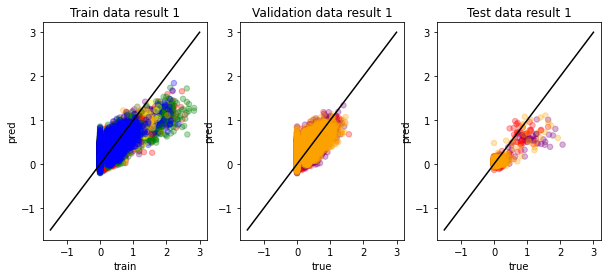

Epoch  7100 Train_loss:  0.18138282  Validation_loss:  0.17328137  Test_loss:  0.21590234
Epoch  7200 Train_loss:  0.18013763  Validation_loss:  0.1720314  Test_loss:  0.21609005
Epoch  7300 Train_loss:  0.17888178  Validation_loss:  0.17091914  Test_loss:  0.21597774
Epoch  7400 Train_loss:  0.17760052  Validation_loss:  0.16990763  Test_loss:  0.21591094
Epoch  7500 Train_loss:  0.1763137  Validation_loss:  0.16881427  Test_loss:  0.21593164
Epoch  7600 Train_loss:  0.17502259  Validation_loss:  0.1675671  Test_loss:  0.21594864
Epoch  7700 Train_loss:  0.1737362  Validation_loss:  0.16637553  Test_loss:  0.21610881
Epoch  7800 Train_loss:  0.17243326  Validation_loss:  0.16535611  Test_loss:  0.21605909
Epoch  7900 Train_loss:  0.17111433  Validation_loss:  0.1643691  Test_loss:  0.21585079
Epoch  8000 Train_loss:  0.16980733  Validation_loss:  0.16297987  Test_loss:  0.2161954


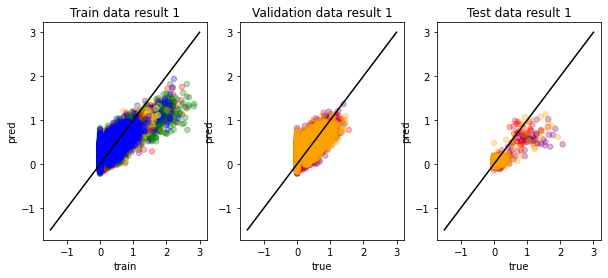

Epoch  8100 Train_loss:  0.1684779  Validation_loss:  0.16201559  Test_loss:  0.21609351
Epoch  8200 Train_loss:  0.16715541  Validation_loss:  0.16088751  Test_loss:  0.21593867
Epoch  8300 Train_loss:  0.1658427  Validation_loss:  0.15956685  Test_loss:  0.21614277
Epoch  8400 Train_loss:  0.16452391  Validation_loss:  0.15843606  Test_loss:  0.21619329
Epoch  8500 Train_loss:  0.1632021  Validation_loss:  0.15745914  Test_loss:  0.21611409
Epoch  8600 Train_loss:  0.16188517  Validation_loss:  0.15621857  Test_loss:  0.21613346
Epoch  8700 Train_loss:  0.16059484  Validation_loss:  0.15475853  Test_loss:  0.21653482
Epoch  8800 Train_loss:  0.15930095  Validation_loss:  0.15382533  Test_loss:  0.21619433
Epoch  8900 Train_loss:  0.15799959  Validation_loss:  0.15269576  Test_loss:  0.2162989
Epoch  9000 Train_loss:  0.15671492  Validation_loss:  0.15140693  Test_loss:  0.21649832


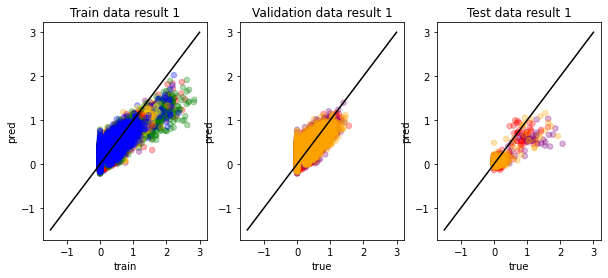

Epoch  9100 Train_loss:  0.1554197  Validation_loss:  0.15029243  Test_loss:  0.21646889
Epoch  9200 Train_loss:  0.1541548  Validation_loss:  0.14924063  Test_loss:  0.2162568
Epoch  9300 Train_loss:  0.1529009  Validation_loss:  0.14807606  Test_loss:  0.21633019
Epoch  9400 Train_loss:  0.15164915  Validation_loss:  0.14687206  Test_loss:  0.21645777
Epoch  9500 Train_loss:  0.15041386  Validation_loss:  0.14553604  Test_loss:  0.2167868
Epoch  9600 Train_loss:  0.1491947  Validation_loss:  0.1443918  Test_loss:  0.21684018
Epoch  9700 Train_loss:  0.14796622  Validation_loss:  0.14342952  Test_loss:  0.21673273
Epoch  9800 Train_loss:  0.14675456  Validation_loss:  0.1422781  Test_loss:  0.21677054
Epoch  9900 Train_loss:  0.14557187  Validation_loss:  0.14128345  Test_loss:  0.21668634
Epoch  10000 Train_loss:  0.14438695  Validation_loss:  0.14018013  Test_loss:  0.21667042


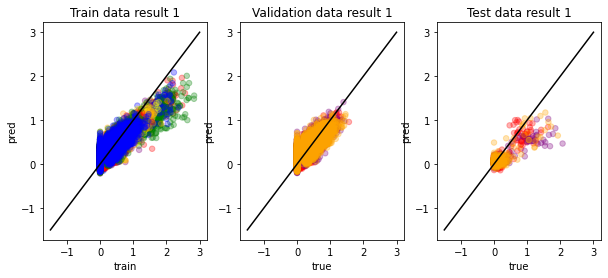

Epoch  10100 Train_loss:  0.14322396  Validation_loss:  0.13914374  Test_loss:  0.21673337
Epoch  10200 Train_loss:  0.14208208  Validation_loss:  0.13798234  Test_loss:  0.21688673
Epoch  10300 Train_loss:  0.14094636  Validation_loss:  0.1370188  Test_loss:  0.2168576
Epoch  10400 Train_loss:  0.13983059  Validation_loss:  0.13581897  Test_loss:  0.2170382
Epoch  10500 Train_loss:  0.13871111  Validation_loss:  0.13480034  Test_loss:  0.21694285
Epoch  10600 Train_loss:  0.13760173  Validation_loss:  0.13390523  Test_loss:  0.21683127
Epoch  10700 Train_loss:  0.13652758  Validation_loss:  0.13265547  Test_loss:  0.21707796
Epoch  10800 Train_loss:  0.13546778  Validation_loss:  0.13171224  Test_loss:  0.21699965
Epoch  10900 Train_loss:  0.13442099  Validation_loss:  0.13068265  Test_loss:  0.21718101
Epoch  11000 Train_loss:  0.1333807  Validation_loss:  0.12983987  Test_loss:  0.21693836


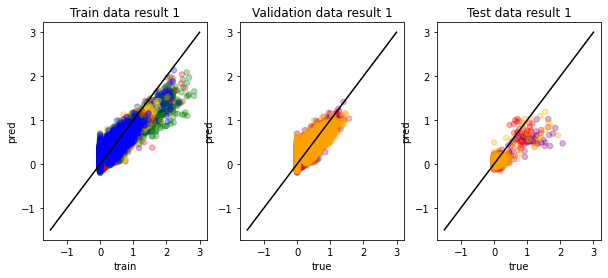

KeyboardInterrupt: 

In [52]:
num_epochs = 50000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)